In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.feature_extraction import FeatureHasher
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
class HR_Data_Prep_Utility(object):
	"""HR_Data_Prep_Utility is used for preparing data for the ML"""

	def __init__(self, dataset, feature_col, target_col, fe_hashing_ratio):
		"""
		Initialize and builds the HR Dataset to be used in training a model
		
		Only the below features are supported
		['MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatusID', 'DeptID', 'PerfScoreID', 'PayRate', 'Termd', 'PositionID', 'State', 'DOB', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination', 'ManagerName', 'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'LastPerformanceReview_Date']

		:param dataset: pandas dataframe read from csv
		:param feature_col: column names of the features
		:param target_col: column name of the target
		"""
		super(HR_Data_Prep_Utility, self).__init__()
		self.emp_ds = dataset
		self.feature_col = feature_col
		self.target_col = target_col
		self.fe_hashing_ratio = fe_hashing_ratio
		self._cat_col = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'DeptID', 'Termd', 'PositionID','State', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'ManagerName', 'RecruitmentSource']
		self._num_col = ['PayRate', 'PerfScoreID', 'Age', 'CurrentCmpyExp', 'EngagementSurvey', 'EmpSatisfaction','SpecialProjectsCount', 'DaysSinceLastRev']
		self._cat_col_onehot = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'Termd', 'CitizenDesc', 'HispanicLatino']
		self._cat_columns_feat_hash = ['DeptID', 'PositionID','State', 'RaceDesc', 'ManagerName', 'RecruitmentSource']


	def get_x_y_data(self):
		"""
		Description
		:param name: description
		:return: Description
		"""
		X, y = self._split_x_y(self.emp_ds)
		X = self._values_fix(X)
		X = self._add_features(X[self.feature_col])
		X = self._missing_values_fix(X)
		X = self._encode_category_features(X, reduction_ratio=self.fe_hashing_ratio)
		y = self._missing_values_fix(y)
		y = self._encode_category_features(y, reduction_ratio=self.fe_hashing_ratio)
		X = self._scale_data(X)
		return X, y


	def _fe_fill_missing_val(self, X, column_name, fe_type):
		"""
		Description
		:param name: description
		:return: Description
		"""
		if(fe_type is 'num'):
			X[column_name + '_missing'] =  np.zeros((len(X.index), 1))
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name + '_missing')] = 1
			X.loc[X[column_name].isna() == True, column_name + '_missing'] = 1
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name)] = 0
			X.loc[X[column_name].isna() == True, column_name] = 0
		elif(fe_type is 'str'):
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name)] = 'Missing'
			X.loc[X[column_name].isna() == True, column_name] = 'Missing'
		return X


	def _fe_category_feature_hashing(self, X, column_name, n_features):
		"""
		Description
		:param name: description
		:return: Description
		"""
		fh = FeatureHasher(n_features=n_features, input_type='string')
		x_features_arr = fh.fit_transform(X[column_name].astype('str')).toarray()
		column_names = np.array([])
		for i in range(n_features):
			column_names = np.append(column_names, column_name+'_'+str(i+1))
		return pd.concat([X, pd.DataFrame(x_features_arr, columns=column_names)], axis=1)


	def _fe_category_one_hot_encoder(self, X, column_name):
		"""
		Description
		:param name: description
		:return: Description
		"""
		x_features_arr = pd.get_dummies(X[column_name])
		x_features_arr.rename(columns=lambda x: column_name+'_' + str(x), inplace=True)
		return pd.concat([X, x_features_arr], axis=1)


	def _split_x_y(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		return X[self.feature_col], X[self.target_col]


	def _add_features(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		now = datetime.now()
		if set(['DateofHire','DateofTermination', 'Termd']).issubset(X.columns):
			X['DateofHire'] = pd.to_datetime(X['DateofHire'], format="%m/%d/%Y")
			X['DateofTermination'] = pd.to_datetime(X['DateofTermination'], format="%m/%d/%y")
			X.loc[X['Termd'] == 0, 'CurrentCmpyExp'] = X['DateofHire'].apply(lambda x: now.year - x.year)
			X.loc[X['Termd'] == 1, 'CurrentCmpyExp'] = (X['DateofTermination'] - X['DateofHire'])/np.timedelta64(1,'Y')
			X = X.drop(['DateofHire', 'DateofTermination'], axis=1)
		if 'LastPerformanceReview_Date' in X.columns:
			X['LastPerformanceReview_Date'] = pd.to_datetime(X['LastPerformanceReview_Date'], format="%m/%d/%Y")
			X['DaysSinceLastRev'] = X['LastPerformanceReview_Date'].apply(lambda x: (now - x).days)
			X = X.drop(['LastPerformanceReview_Date'], axis=1)
		if 'DOB' in X.columns:
			X['DOB'] = pd.to_datetime(X['DOB'], format="%d-%m-%Y")
			X['Age'] = X['DOB'].apply(lambda x: now.year - x.year)
			X = X.drop(['DOB'], axis=1)
		return X


	def _format_date_of_termination(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		pattern1_match = X['DateofTermination'].str.match(pat = '^(0[1-9]|1[012])/(0[1-9]|1[0-9]|2[0-9]|3[01])/([0-9]{2})$')
		dates_p1 = pd.to_datetime((X[pattern1_match==True])['DateofTermination'], format="%m/%d/%y")
		pattern2_match = X['DateofTermination'].str.match(pat = '^((19|2[0-9])[0-9]{2})/(0[1-9]|1[012])/(0[1-9]|[12][0-9]|3[01])$')
		dates_p2 = pd.to_datetime((X[pattern2_match==True])['DateofTermination'], format="%Y/%m/%d")
		combined_dates = dates_p1.append(dates_p2)
		X = X.drop(['DateofTermination'], axis=1)
		X.at[combined_dates.index, 'DateofTermination'] = combined_dates.values
		return X


	def _missing_values_fix(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		#Added features are missed from this.. 
		cat_columns = list(set(self.feature_col) & set(self._cat_col))
		num_columns = list(set(self.feature_col) & set(self._num_col)) + ['CurrentCmpyExp', 'DaysSinceLastRev', 'Age']
		for column in cat_columns:
			if column in X.columns:
				X = self._fe_fill_missing_val(X, column, 'str')
		for column in num_columns:
			if column in X.columns:
				X = self._fe_fill_missing_val(X, column, 'num')
		return X


	def _values_fix(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		if 'HispanicLatino' in X.columns:
			X.loc[X['HispanicLatino']=='yes', 'HispanicLatino'] = 'Yes'
			X.loc[X['HispanicLatino']=='no', 'HispanicLatino'] = 'No'
		return X


	def _encode_category_features(self, X, reduction_ratio):
		"""
		Description
		:param name: description
		:return: Description
		"""
		cat_columns_oh = list(set(self.feature_col) & set(self._cat_col_onehot))
		cat_columns_fh = list(set(self.feature_col) & set(self._cat_columns_feat_hash))
		for column in cat_columns_oh:
			if column in X.columns:
				X = self._fe_category_one_hot_encoder(X, column)
		for column in cat_columns_fh:
			if column in X.columns:
				X = self._fe_category_feature_hashing(X, column, int(len(X[column].unique())*reduction_ratio))
		drop_encoded_fe = []
		for column in cat_columns_oh + cat_columns_fh:
			if column in X.columns:
				drop_encoded_fe.append(column)
		X = X.drop(drop_encoded_fe, axis=1)
		return X


	def _scale_data(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		scaler = StandardScaler()
		scaler.fit(X)
		return pd.DataFrame(scaler.transform(X))

In [3]:
hr_ds = pd.read_csv("C:/Users/nravi/Datasets/HRDataset_v13_Working_BU.csv")
hr_ds.describe() 

,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Zip,ManagerID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30
count,3.100000e+02,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,302.000000,310.000000,310.000000,310.000000,207.0
mean,1.199745e+09,0.396774,0.809677,0.429032,2.396774,4.606452,2.983871,0.093548,31.284806,0.332258,16.838710,6569.732258,14.579470,3.332097,3.890323,1.209677,0.0
std,1.829600e+08,0.490019,0.944702,0.495738,1.795533,1.082349,0.577124,0.291670,15.383615,0.471785,6.232272,16933.864054,8.090352,1.290590,0.910690,2.352009,0.0
min,6.020003e+08,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,14.000000,0.000000,1.000000,1013.000000,1.000000,1.030000,1.000000,0.000000,0.0
25%,1.101024e+09,0.000000,0.000000,0.000000,1.000000,5.000000,3.000000,0.000000,20.000000,0.000000,18.000000,1901.250000,10.000000,2.082500,3.000000,0.000000,0.0
50%,1.203032e+09,0.000000,1.000000,0.000000,1.000000,5.000000,3.000000,0.000000,24.000000,0.000000,19.000000,2132.000000,15.000000,3.470000,4.000000,0.000000,0.0
75%,1.378814e+09,1.000000,1.000000,1.000000,5.000000,5.000000,3.000000,0.000000,45.315000,1.000000,20.000000,2357.000000,19.000000,4.520000,5.000000,0.000000,0.0
max,1.988300e+09,1.000000,4.000000,1.000000,5.000000,6.000000,4.000000,1.000000,80.000000,1.000000,30.000000,98052.000000,39.000000,5.000000,5.000000,8.000000,0.0


In [4]:
X_feature = ['MarriedID', 'MaritalStatusID', 'EmpStatusID', 'DeptID', 
             'PerfScoreID', 'Termd', 'PositionID','GenderID', 'State', 'DOB', 'CitizenDesc', 
             'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination', 'ManagerName', 
             'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 
             'LastPerformanceReview_Date']
X_feature

['MarriedID',
 'MaritalStatusID',
 'EmpStatusID',
 'DeptID',
 'PerfScoreID',
 'Termd',
 'PositionID',
 'GenderID',
 'State',
 'DOB',
 'CitizenDesc',
 'HispanicLatino',
 'RaceDesc',
 'DateofHire',
 'DateofTermination',
 'ManagerName',
 'RecruitmentSource',
 'EngagementSurvey',
 'EmpSatisfaction',
 'SpecialProjectsCount',
 'LastPerformanceReview_Date']

In [5]:
y_feature = ['PayRate']
y_feature 

['PayRate']

In [6]:
hr_data = HR_Data_Prep_Utility(hr_ds, X_feature, y_feature, 0.5)
hr_data

In [7]:
X, y = hr_data.get_x_y_data()
X

C:\Users\nravi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.027992,-1.002786,-2.079060,2.039987,2.356114,0.768561,-0.953088,0.0,0.0,0.0,...,-0.330014,-1.975152,0.538461,-0.393176,-2.354078,0.715678,1.898543,-1.429047,1.763322,1.471007
1,0.027992,1.294446,0.120628,1.188275,0.268304,0.759826,-0.614261,0.0,0.0,0.0,...,-0.330014,-1.975152,0.538461,-0.393176,-2.354078,0.715678,1.898543,-1.429047,1.763322,1.471007
2,0.027992,0.440745,1.220472,1.614131,0.268304,0.755458,-0.840145,0.0,0.0,0.0,...,-0.330014,-1.975152,0.538461,-0.393176,-2.354078,0.715678,1.898543,0.505471,-0.582729,-0.736216
3,0.027992,-0.071476,-0.979216,1.188275,-1.764249,-1.415211,-0.727203,0.0,0.0,0.0,...,-0.330014,-1.975152,0.538461,-0.393176,-2.354078,0.715678,1.898543,0.505471,-0.582729,-0.736216
4,0.027992,1.294446,-0.979216,1.614131,-0.079664,0.768561,-1.066030,0.0,0.0,0.0,...,-0.330014,-1.975152,0.538461,-0.393176,-2.354078,0.715678,1.898543,0.505471,-0.582729,-0.736216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.027992,-1.383071,1.220472,2.891699,0.268304,0.646270,2.999895,0.0,0.0,0.0,...,1.893994,-0.240599,1.556283,-0.393176,0.070388,0.715678,1.085631,0.505471,-0.582729,-0.736216
306,0.027992,0.875357,1.220472,2.039987,0.268304,0.803501,-0.840145,0.0,0.0,0.0,...,1.893994,-0.240599,1.556283,-0.393176,0.070388,0.715678,1.085631,0.505471,-0.582729,-0.736216
307,0.027992,-0.048193,0.120628,1.614131,-0.427632,0.772929,-0.501318,0.0,0.0,0.0,...,1.893994,-0.240599,1.556283,-0.393176,0.070388,0.715678,1.085631,-0.461788,-0.582729,0.588118
308,0.027992,1.294446,-0.979216,1.188275,0.268304,0.825339,1.531644,0.0,0.0,0.0,...,1.893994,-0.240599,1.556283,-0.393176,0.070388,0.715678,1.085631,0.505471,-0.582729,-0.736216


In [8]:
print(X.shape)
print(y.shape)

(310, 91)
(310, 1)


# Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=45, 
                                                    train_size=0.75, test_size=0.25)

# Build the neural network

In [10]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=11,activation = 'relu', input_shape=[91]), 
                             tf.keras.layers.Dense(units=1)])
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))


# Training using Neural network

Train on 232 samples
Epoch 1/35
232/232 [==============================] - 0s 241us/sample - loss: 831.8223
Epoch 2/35
232/232 [==============================] - 0s 69us/sample - loss: 245.3324
Epoch 3/35
232/232 [==============================] - 0s 52us/sample - loss: 128.6686
Epoch 4/35
232/232 [==============================] - 0s 52us/sample - loss: 91.3444
Epoch 5/35
232/232 [==============================] - 0s 69us/sample - loss: 49.4962
Epoch 6/35
232/232 [==============================] - 0s 69us/sample - loss: 49.1481
Epoch 7/35
232/232 [==============================] - 0s 69us/sample - loss: 28.7958
Epoch 8/35
232/232 [==============================] - 0s 69us/sample - loss: 23.8638
Epoch 9/35
232/232 [==============================] - 0s 69us/sample - loss: 19.9311
Epoch 10/35
232/232 [==============================] - 0s 69us/sample - loss: 16.6108
Epoch 11/35
232/232 [==============================] - 0s 52us/sample - loss: 14.2829
Epoch 12/35
232/232 [=================

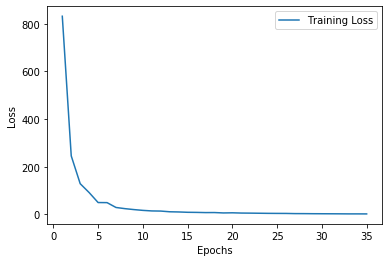

In [11]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
trained_model = model.fit(X_train, y_train, epochs=35, batch_size = 50)
loss_values = trained_model.history['loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(X_test)
y_pred.reshape(-1,1)

array([[23.816385],
       [23.849583],
       [24.167688],
       [36.951366],
       [22.511639],
       [34.620663],
       [27.292212],
       [57.553345],
       [18.922873],
       [49.675484],
       [20.968523],
       [14.161114],
       [31.42621 ],
       [25.022617],
       [21.225235],
       [28.159937],
       [21.341322],
       [16.022419],
       [52.327827],
       [26.324923],
       [50.897705],
       [24.038834],
       [14.690696],
       [32.52019 ],
       [16.091383],
       [60.454918],
       [17.778107],
       [46.99904 ],
       [24.800539],
       [18.511213],
       [33.177128],
       [23.424171],
       [39.039997],
       [19.877533],
       [30.03497 ],
       [15.561335],
       [15.990607],
       [18.02249 ],
       [31.037683],
       [32.631   ],
       [29.604101],
       [23.674103],
       [19.683628],
       [61.160812],
       [74.85678 ],
       [10.98195 ],
       [15.334722],
       [30.224741],
       [23.988953],
       [45.60577 ],


In [13]:
print(r2_score(y_test,y_pred))

0.6123943893230279


In [14]:
np.sqrt(mean_squared_error(y_test, y_pred))

9.218658302906977